## Imports

In [1]:
# Enable fast weights download and upload
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
import torch
import clip
from PIL import Image
import json
from typing import List, Dict, Union, Tuple, Optional
import numpy as np
import logging
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from collections import defaultdict
import re
import spacy
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import inflect
import logging
import nltk

In [4]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

## Text Analyzer

In [6]:
class TextAnalyzer:
    def __init__(self, log_file: str = "text_analysis.log"):
        """
        Initialize enhanced text content analyzer with advanced NLP capabilities.
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Initialize NLP tools
        try:
            self.nlp = spacy.load("en_core_web_sm")
        except OSError:
            #import subprocess
            #subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
            self.nlp = spacy.load("en_core_web_sm")
            
        self.lemmatizer = WordNetLemmatizer()
        self.inflect_engine = inflect.engine()
        
        # Download required NLTK data
        #try:
        #    nltk.data.find('corpora/wordnet')
        #except LookupError:
        #    nltk.download('wordnet')
        #    nltk.download('averaged_perceptron_tagger')

        self.evasion_patterns = {
            "separators": [" ", ".", "-", "_", ",", ";", ":", "/", "\\", "|", "+"],
            "substitutions": {
                "a": ["@", "4", "α", "а"],
                "e": ["3", "€", "е"],
                "i": ["1", "!", "|", "і"],
                "o": ["0", "θ", "о"],
                "s": ["5", "$", "ѕ"],
                "t": ["7", "+", "т"],
            },
            "common_leetspeak": {
                "a": "4",
                "b": "8",
                "e": "3",
                "g": "6",
                "i": "1",
                "o": "0",
                "s": "5",
                "t": "7",
                "z": "2"
            }
        }
        
        # Setup logging
        self.setup_logging(log_file)
        
        # Load config and expand concepts
        self.config = self.load_config()
        self.expand_harmful_concepts()
        # Add common evasion patterns
        
    def generate_evasion_variants(self, word: str) -> List[str]:
        """
        Generate common evasion variants of a word
        """
        
        variants = set([word])
        
        # Generate separator variants (e.g., "d o g", "d.o.g")
        for sep in self.evasion_patterns["separators"]:
            variants.add(sep.join(word))
            variants.add(sep.join(list(word)))
        
        # Generate letter substitution variants
        for char in word.lower():
            if char in self.evasion_patterns["substitutions"]:
                for sub in self.evasion_patterns["substitutions"][char]:
                    variants.add(word.replace(char, sub))
        
        # Generate leetspeak variants
        leetword = word.lower()
        for char, replacement in self.evasion_patterns["common_leetspeak"].items():
            leetword = leetword.replace(char, replacement)
        variants.add(leetword)
        
        return list(variants)
    
    def setup_logging(self, log_file: str):
        """
        Configure logging
        """
        
        logging.basicConfig(
            filename=log_file,
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)
        
    def load_config(self) -> Dict:
        """
        Load shared configuration file with harmful concepts
        """
        
        try:
            with open("clip_config.json", "r") as f:
                return json.load(f)
        except FileNotFoundError:
            self.logger.warning("Config file not found. Using default config.")
            default_config = {
                "harmful_concepts": {
                    "dog": {
                        "threshold": 0.3,
                        "severity": "high",
                        "variations": [
                            "doggy", "doggo", "pupper", "puppy", "hound", "pooch",
                            "canine", "pup", "mutt", "woofer", "goodboy", "k9", "mutt",
                            "man's best friend", "bitch", "whelp", "mong", "cur", "mongrel",
                            "dawg", "doge", "doggie", "pups", "puppers", "doggos",
                            "dog dog", "d o g", "d.o.g", "d0g", "d@g", 
                            "Canis lupus familiaris", "Canis lupus", "Canis"
                        ]
                    }
                },
                "batch_size": 4,
                "default_threshold": 0.3
            }
            with open("clip_config.json", "w") as f:
                json.dump(default_config, f, indent=2)
            return default_config

    def get_synonyms(self, word: str) -> List[str]:
        """
        Get synonyms for a word using WordNet
        """
        
        synonyms = set()
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonyms.add(lemma.name().lower())
        return list(synonyms)

    def get_word_variations(self, word: str) -> List[str]:
        """
        Generate common variations of a word
        """
        
        variations = set([word])
        
        # Add lowercase and uppercase variations
        variations.add(word.lower())
        variations.add(word.title())
        
        # Add plural/singular forms
        singular = self.inflect_engine.singular_noun(word)
        if singular:
            variations.add(singular)
        plural = self.inflect_engine.plural(word)
        if plural:
            variations.add(plural)
            
        # Add lemmatized form
        variations.add(self.lemmatizer.lemmatize(word))
        
        # Add common suffix variations
        suffixes = ['y', 'ie', 'ey', 'er', 'est', 'ing', 'ed']
        for suffix in suffixes:
            variations.add(f"{word}{suffix}")
            variations.add(f"{word.rstrip('e')}{suffix}")
            
        return list(variations)

    def expand_harmful_concepts(self):
        """
        Enhanced expansion of harmful concepts with evasion detection
        """
        
        self.expanded_concepts = {}
        self.concept_patterns = {}
        
        for concept, config in self.config["harmful_concepts"].items():
            variations = set([concept])
            
            # Add configured variations
            if "variations" in config:
                variations.update(config["variations"])
            
            # Add synonyms and their variations
            for word in list(variations):
                synonyms = self.get_synonyms(word)
                variations.update(synonyms)
                
                # Add diminutives and slang variations
                diminutives = [f"{word}y", f"{word}ie", f"{word}ey", f"{word}let"]
                variations.update(diminutives)
            
            # Generate word variations including evasion attempts
            all_variations = set()
            for word in variations:
                # Add basic word variations
                word_variations = self.get_word_variations(word)
                all_variations.update(word_variations)
                
                # Add evasion variants for each variation
                for variant in word_variations:
                    all_variations.update(self.generate_evasion_variants(variant))
            
            # Create more flexible regex pattern
            pattern_parts = []
            for variation in all_variations:
                # Allow for optional characters between letters
                pattern = r'\b'
                for char in variation:
                    pattern += re.escape(char) + r'[\s\W_]*'
                pattern += r'\b'
                pattern_parts.append(pattern)
            
            pattern_str = '|'.join(pattern_parts)
            self.concept_patterns[concept] = re.compile(pattern_str, re.IGNORECASE | re.UNICODE)
            
            # Store expanded concepts
            self.expanded_concepts[concept] = list(all_variations)
            
            self.logger.info(f"Expanded concept '{concept}' to {len(all_variations)} variations")
            self.logger.debug(f"Variations for '{concept}': {sorted(all_variations)}")

    def preprocess_text(self, text: str) -> str:
        """Preprocess text for analysis"""
        # Use spaCy for basic preprocessing
        doc = self.nlp(text)
        
        # Expand contractions
        processed_text = []
        for token in doc:
            # Handle common contractions
            word = token.text.lower()
            if word in ["'s", "'re", "'ve", "'ll", "'d", "'m"]:
                continue
            processed_text.append(token.text)
            
        return " ".join(processed_text)

    def analyze_text(self, text: str) -> Dict[str, float]:
        """Enhanced text analysis with context awareness"""
        results = {}
        processed_text = self.preprocess_text(text)
        
        # Create sliding windows for context analysis
        words = processed_text.split()
        windows = [
            ' '.join(words[i:i+5])  # Look at 5-word windows
            for i in range(len(words))
        ]
        
        for concept, pattern in self.concept_patterns.items():
            all_matches = []
            
            # Check full text
            full_matches = pattern.findall(processed_text)
            all_matches.extend(full_matches)
            
            # Check each window for context
            for window in windows:
                window_matches = pattern.findall(window)
                all_matches.extend(window_matches)
            
            if all_matches:
                threshold = self.config["harmful_concepts"][concept]["threshold"]
                unique_variations = len(set(match.lower() for match in all_matches))
                total_variations = len(self.expanded_concepts[concept])
                
                # Enhanced probability calculation
                variation_weight = unique_variations / total_variations
                count_weight = len(all_matches) * 0.1
                context_weight = len(set(windows)) / len(windows)  # How spread out the matches are
                
                prob = min(1.0, threshold + variation_weight + count_weight + context_weight)
                results[concept] = prob
                
                self.logger.info(
                    f"Found {len(all_matches)} mentions of '{concept}' "
                    f"({unique_variations} unique variations) "
                    f"with probability {prob}"
                )
                self.logger.debug(f"Matched terms: {all_matches}")
            else:
                results[concept] = 0.0
        
        return results

    def check_harmful_content(self, 
                            text_results: Dict[str, float],
                            strict_mode: bool = True) -> Tuple[bool, List[str]]:
        """Enhanced harmful content check with strict mode"""
        detected_concepts = []
        
        for concept, prob in text_results.items():
            config = self.config["harmful_concepts"].get(concept, {})
            base_threshold = config.get("threshold", self.config["default_threshold"])
            
            # In strict mode, lower the threshold for detection
            threshold = base_threshold * 0.8 if strict_mode else base_threshold
            
            self.logger.info(
                f"Checking concept '{concept}': probability={prob:.3f}, "
                f"threshold={threshold} (strict_mode={strict_mode})"
            )
            
            if prob >= threshold:
                detected_concepts.append(concept)
                self.logger.warning(
                    f"Harmful concept '{concept}' detected with probability {prob:.3f}"
                )
            else:
                self.logger.info(f"Concept '{concept}' below threshold. Probability: {prob:.3f}")
                
        return bool(detected_concepts), detected_concepts

## CLIP Analyzer

In [11]:
class CLIPAnalyzer:
    def __init__(self, 
                clip_model: str = "ViT-B/32",
                log_file: str = "clip_analysis.log"):
        """
        Initialize CLIP analyzer with model and logging configuration.
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load(clip_model, device=self.device)
        
        # Setup logging
        self.setup_logging(log_file)
        
        # Load config
        self.config = self.load_config()
        
    def setup_logging(self, log_file: str):
        """Configure logging"""
        logging.basicConfig(
            filename=log_file,
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)

    def load_config(self) -> Dict:
        """Load configuration including harmful concepts and thresholds"""
        try:
            with open("clip_config.json", "r") as f:
                return json.load(f)
        except FileNotFoundError:
            default_config = {
                "harmful_concepts": {
                    "dog": {
                        "threshold": 0.3,  # Adjusted threshold
                        "severity": "high"
                    }
                },
                "batch_size": 4,
                "default_threshold": 0.3
            }
            with open("clip_config.json", "w") as f:
                json.dump(default_config, f, indent=2)
            return default_config

    def preprocess_image(self, image: Union[str, Image.Image]) -> torch.Tensor:
        """Preprocess single image"""
        if isinstance(image, str):
            image = Image.open(image)
        elif not isinstance(image, Image.Image):
            raise ValueError("Image must be PIL Image or path to image")
            
        return self.preprocess(image).unsqueeze(0).to(self.device)

    def analyze_single_image(self, image: Union[str, Image.Image]) -> Dict[str, float]:
        """Analyze a single image"""
        image_input = self.preprocess_image(image)
        
        # Add a "safe" concept to compare against harmful concepts
        concepts = list(self.config["harmful_concepts"].keys()) + ["a photograph"]
        text = clip.tokenize(concepts).to(self.device)
        
        with torch.no_grad():
            image_features = self.model.encode_image(image_input)
            text_features = self.model.encode_text(text)
            
            # Calculate similarity
            logits_per_image, _ = self.model(image_input, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()[0]
            
        # Only include harmful concepts in results
        results = {concept: float(prob) for concept, prob in zip(concepts[:-1], probs[:-1])}
        
        # Log the complete probability distribution for debugging
        self.logger.info(f"Complete probability distribution: {dict(zip(concepts, probs))}")
        self.logger.info(f"Harmful concepts probabilities: {results}")
        
        return results

    def check_harmful_content(self, 
                            image_results: Dict[str, float]) -> Tuple[bool, List[str]]:
        """Check if image contains harmful content above thresholds"""
        detected_concepts = []
        
        for concept, prob in image_results.items():
            config = self.config["harmful_concepts"].get(concept, {})
            threshold = config.get("threshold", self.config["default_threshold"])
            
            # Added debug logging
            self.logger.info(f"Checking concept '{concept}': probability={prob:.3f}, threshold={threshold}")
            
            if prob >= threshold:
                detected_concepts.append(concept)
                self.logger.warning(f"Harmful concept '{concept}' detected with probability {prob:.3f}")
            else:
                self.logger.info(f"Concept '{concept}' below threshold. Probability: {prob:.3f}")
                
        return bool(detected_concepts), detected_concepts

In [13]:
'''
INFERENCE-LEVEL WRAPPER. DEPRECATED FOR A MODEL-LEVEL WRAPPER.
'''

from functools import wraps
from typing import Optional, List, Union, Callable, Any
from PIL import Image
import hashlib
import inspect
import logging
from datetime import datetime
import json

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class GuardrailEnforcer:
    """
    Singleton class to enforce guardrails and maintain state
    """
    
    _instance = None
    
    def __new__(cls):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
            cls._instance.initialize()
        return cls._instance
    
    def initialize(self):
        self.bypass_attempts = 0
        self.last_check_time = datetime.now()
        self.processed_hashes = set()
        
    def record_attempt(self, prompt: str):
        """
        Record and analyze potential bypass attempts
        """
        
        self.bypass_attempts += 1
        if self.bypass_attempts > 10:
            logger.warning(f"Multiple bypass attempts detected: {self.bypass_attempts}")
            # Could implement additional security measures here
            
    def validate_input(self, prompt: str) -> bool:
        """
        Validate input for potential bypass attempts
        """
        
        # Check for common bypass patterns
        bypass_patterns = [
            "ignore previous", "bypass", "override",
            "skip check", "disable guardrail"
        ]
        return not any(pattern in prompt.lower() for pattern in bypass_patterns)

def enforce_guardrails(func: Callable) -> Callable:
    """
    Decorator to enforce guardrails at the function level
    """
    
    @wraps(func)
    def wrapper(*args, **kwargs):
        enforcer = GuardrailEnforcer()
        
        # Extract prompt from args or kwargs
        prompt = None
        if 'prompt' in kwargs:
            prompt = kwargs['prompt']
        elif len(args) > 3:  # Based on the original function signature
            prompt = args[3]
            
        if not prompt:
            raise ValueError("No prompt provided")
            
        # Input validation
        if not enforcer.validate_input(prompt):
            logger.warning(f"Potential bypass attempt detected in prompt: {prompt}")
            enforcer.record_attempt(prompt)
            return ["Access denied: Invalid input detected"]
            
        # Calculate input hash to prevent replay attacks
        input_hash = hashlib.sha256(prompt.encode()).hexdigest()
        if input_hash in enforcer.processed_hashes:
            logger.warning(f"Duplicate input detected: {prompt}")
            return ["Access denied: Duplicate input detected"]
        enforcer.processed_hashes.add(input_hash)
        
        try:
            # Call the original function
            result = func(*args, **kwargs)
            
            # Post-processing validation
            if isinstance(result, list) and result:
                # Check for potential harmful content in response
                harmful_patterns = ["harmful_content", "restricted_content", "bypass_successful"]
                if any(pattern in str(result).lower() for pattern in harmful_patterns):
                    logger.error(f"Harmful content detected in response: {result}")
                    return ["Response filtered due to potential harmful content"]
                    
            return result
            
        except Exception as e:
            logger.error(f"Error in guardrails processing: {str(e)}")
            return ["Error: Unable to process request"]
            
    return wrapper

def verify_components(
    text_analyzer: Any,
    clip_analyzer: Optional[Any],
    llm_processor: Any,
    llm_model: Any
) -> bool:
    """
    Verify integrity of processing components
    """
    
    required_methods = {
        'text_analyzer': ['analyze_text', 'check_harmful_content'],
        'clip_analyzer': ['analyze_single_image', 'check_harmful_content'],
        'llm_processor': ['apply_chat_template', 'batch_decode'],
        'llm_model': ['generate']
    }
    
    try:
        for component_name, methods in required_methods.items():
            component = locals()[component_name]
            if component is None and component_name == 'clip_analyzer':
                continue
            if component is None:
                logger.error(f"Missing required component: {component_name}")
                return False
            for method in methods:
                if not hasattr(component, method):
                    logger.error(f"Missing required method {method} in {component_name}")
                    return False
        return True
    except Exception as e:
        logger.error(f"Component verification failed: {str(e)}")
        return False

@enforce_guardrails
def process_with_guardrails(
    images: Optional[List[Union[str, Image.Image]]],
    llm_processor,
    llm_model,
    prompt: str
) -> List[str]:
    """Process images and/or text with enhanced guardrails."""
    # Verify components before processing
    if not verify_components(
        text_analyzer=TextAnalyzer(),
        clip_analyzer=CLIPAnalyzer() if images else None,
        llm_processor=llm_processor,
        llm_model=llm_model
    ):
        return ["Error: System configuration invalid"]
    
    # Initialize analyzers with enhanced logging
    text_analyzer = TextAnalyzer()
    clip_analyzer = CLIPAnalyzer() if images else None
    
    logger.info(f"Processing request - Prompt: {prompt[:100]}...")
    
    # Check text content first with enhanced analysis
    text_results = text_analyzer.analyze_text(prompt)
    is_text_harmful, text_concepts = text_analyzer.check_harmful_content(text_results)
    
    if is_text_harmful:
        logger.warning(f"Harmful content detected in prompt: {text_concepts}")
        return [f"Unable to process: Prompt contains restricted content: {', '.join(text_concepts)}"]
    
    # Process text-only or image+text with enhanced monitoring
    try:
        if not images:
            messages = [{"role": "user", "content": prompt}]
            input_text = llm_processor.apply_chat_template(messages, add_generation_prompt=True)
            inputs = llm_processor(text=input_text, return_tensors="pt").to("cuda")
            generate_ids = llm_model.generate(**inputs, max_new_tokens=500)
            response = llm_processor.batch_decode(
                generate_ids[:, inputs['input_ids'].shape[1]:],
                skip_special_tokens=True
            )[0]
            
            # Post-process response
            if len(response) > 10000:  # Example threshold
                logger.warning("Response length exceeds threshold")
                response = response[:10000] + "... [truncated]"
                
            return [response]
            
        # Process images with enhanced monitoring
        responses = []
        for idx, image in enumerate(images):
            logger.info(f"Processing image {idx + 1}")
            
            # Verify image integrity
            if isinstance(image, str):
                try:
                    Image.open(image).verify()
                except Exception as e:
                    logger.error(f"Invalid image file: {str(e)}")
                    responses.append(f"Image {idx + 1}: Invalid image file")
                    continue
                    
            image_results = clip_analyzer.analyze_single_image(image)
            is_image_harmful, detected_concepts = clip_analyzer.check_harmful_content(image_results)
            
            if is_image_harmful:
                logger.warning(f"Harmful content detected in image {idx + 1}: {detected_concepts}")
                responses.append(
                    f"Image {idx + 1}: Unable to process due to restricted content: {', '.join(detected_concepts)}"
                )
            else:
                messages = [
                    {"role": "user", "content": [
                        {"type": "text", "text": f"Describe image {idx + 1}: {prompt}"},
                        {"type": "image"}
                    ]}
                ]
                
                input_text = llm_processor.apply_chat_template(messages, add_generation_prompt=True)
                inputs = llm_processor(text=input_text, images=[image], return_tensors="pt").to("cuda")
                generate_ids = llm_model.generate(**inputs, max_new_tokens=500)
                output = llm_processor.batch_decode(
                    generate_ids[:, inputs['input_ids'].shape[1]:],
                    skip_special_tokens=True
                )[0]
                
                responses.append(f"Image {idx + 1}: {output}")
                
        return responses
        
    except Exception as e:
        logger.error(f"Processing error: {str(e)}")
        return ["Error: Processing failed"]

In [10]:
'''
MODEL-LEVEL WRAPPER WITH TEXT PROCESSING ONLY.
'''

import torch
from torch.nn import Module
from transformers import PreTrainedModel, PreTrainedTokenizer
from typing import Any, Dict, List, Optional, Union, Tuple
import functools
import inspect
from contextlib import contextmanager
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class GuardedModelWrapper:
    """
    Wrapper that enforces guardrails at the model level with graceful handling
    """
    
    def __init__(self, model: PreTrainedModel, processor: PreTrainedTokenizer):
        self._original_model = model
        self._original_processor = processor
        self.text_analyzer = TextAnalyzer()
        self._setup_guardrails()

    def _setup_guardrails(self):
        """
        Set up guardrails by wrapping critical methods
        """
        
        # Wrap the model's generate method
        self._original_generate = self._original_model.generate
        self._original_model.generate = self._wrap_generate()

        # Wrap the processor's methods
        self._original_batch_decode = self._original_processor.batch_decode
        self._original_processor.batch_decode = self._wrap_batch_decode()

        # Wrap __call__ methods
        self._original_model_call = self._original_model.__call__
        self._original_processor_call = self._original_processor.__call__
        
        self._original_model.__call__ = self._wrap_model_call()
        self._original_processor.__call__ = self._wrap_processor_call()

        # Prevent direct attribute access/modification
        self._lock_attributes()

    def _get_restricted_response(self, content_name: str) -> torch.Tensor:
        """Generate a friendly response for restricted content
        
        Args:
            content_name (str): The name of the restricted content
            
        Returns:
            torch.Tensor: Processed response as tensor that mimics generate() output
        """
        if isinstance(content_name, (list, tuple)):
            content_name = ', '.join(str(item) for item in content_name)
        else:
            content_name = str(content_name)
        #print(f"Error in generate_response due to restricted content: {content_name}")
        
        response_text = f"I apologize, but I encountered an error while processing your request due to restricted content: {content_name}."
        
        # Use a safe default context length for Llama models
        # Most Llama models use 2048 or 4096 as context window
        default_context_length = 2048
        try:
            # Try to get context length from model config if available
            context_length = getattr(self._original_model.config, 'max_context_length', None) or \
                            getattr(self._original_model.config, 'context_length', None) or \
                            getattr(self._original_model.config, 'max_sequence_length', None) or \
                            default_context_length
        except AttributeError:
            context_length = default_context_length
        
        original_input_length = context_length // 4  # Use a smaller portion for the input
        
        # Create the response tensor
        response_ids = self._original_processor(
            None,
            response_text,
            return_tensors="pt",
            add_special_tokens=True
        )["input_ids"].to(self._original_model.device)
        
        # Create a tensor that has the same format as model.generate() output
        pad_token_id = self._original_processor.tokenizer.eos_token_id
        full_tensor = torch.full(
            (1, original_input_length + response_ids.size(1)), 
            pad_token_id, 
            dtype=torch.long,
            device=self._original_model.device
        )
        
        # Fill the first part with pad tokens (representing original input)
        full_tensor[:, :original_input_length] = pad_token_id
        
        # Place the response in the second part
        full_tensor[:, original_input_length:original_input_length + response_ids.size(1)] = response_ids
        
        # Debug print using the same slicing as the inference code
        debug_output = self._original_processor.batch_decode(
            full_tensor[:, original_input_length:],
            skip_special_tokens=True
        )
        #print("Debug - Tokenized and decoded message:", debug_output)
        
        return full_tensor
    
    def _wrap_generate(self):
        """Wrap the model's generate method with guardrails"""
        @functools.wraps(self._original_generate)
        def wrapped_generate(*args, **kwargs):
            # Extract input_ids from args or kwargs
            input_ids = kwargs.get('input_ids', args[0] if args else None)
            
            if input_ids is None:
                return self._get_restricted_response("invalid input")
            
            # Decode input to check content before generation
            decoded_input = self._original_processor.batch_decode(input_ids, skip_special_tokens=True)
            
            # Apply guardrails to input
            is_safe, restricted_content = self._check_input_safety(decoded_input)
            if not is_safe:
                return self._get_restricted_response(restricted_content)
            
            # Call original generate
            outputs = self._original_generate(*args, **kwargs)
            
            # Apply guardrails to output
            is_safe, restricted_content = self._check_output_safety(outputs)
            if not is_safe:
                return self._get_restricted_response(restricted_content)
                
            return outputs
            
        return wrapped_generate
    
    def _wrap_batch_decode(self):
        """Wrap the processor's batch_decode method with guardrails"""
        @functools.wraps(self._original_batch_decode)
        def wrapped_batch_decode(*args, **kwargs):
            outputs = self._original_batch_decode(*args, **kwargs)
            
            # Apply guardrails to decoded output
            is_safe, restricted_content = self._check_output_safety(outputs)
            if not is_safe:
                return self._get_restricted_response(self, restricted_content)
                
            return outputs
            
        return wrapped_batch_decode
    
    def _wrap_model_call(self):
        """Wrap the model's __call__ method"""
        @functools.wraps(self._original_model_call)
        def wrapped_call(*args, **kwargs):
            # Apply input validation
            is_valid, restricted_content = self._validate_model_input(*args, **kwargs)
            if not is_valid:
                return self._get_restricted_response(restricted_content)
                
            return self._original_model_call(*args, **kwargs)
            
        return wrapped_call
    
    def _wrap_processor_call(self):
        """Wrap the processor's __call__ method"""
        @functools.wraps(self._original_processor_call)
        def wrapped_call(*args, **kwargs):
            # Apply input validation
            is_valid, restricted_content = self._validate_processor_input(*args, **kwargs)
            if not is_valid:
                return self._get_restricted_response(restricted_content)
                
            return self._original_processor_call(*args, **kwargs)
            
        return wrapped_call
    
    def _lock_attributes(self):
        """Prevent direct modification of critical attributes"""
        def make_read_only(obj):
            original_setattr = obj.__setattr__
            
            def new_setattr(name, value):
                if hasattr(obj, name):
                    raise SecurityException(f"Cannot modify {name}: Protected attribute")
                original_setattr(name, value)
                
            obj.__setattr__ = new_setattr
            
        make_read_only(self._original_model)
        make_read_only(self._original_processor)
    
    def _check_input_safety(self, input_text: Union[str, List[str]]) -> Tuple[bool, str]:
        """Check if input is safe to process"""
        if isinstance(input_text, str):
            input_text = [input_text]
            
        for text in input_text:
            results = self.text_analyzer.analyze_text(text)
            is_text_harmful, content_type = self.text_analyzer.check_harmful_content(results)
            if is_harmful:
                return False, content_type
        return True, ""
    
    def _check_output_safety(self, output: Union[str, List[str], torch.Tensor]) -> Tuple[bool, str]:
        """Check if output is safe"""
        #if isinstance(output, torch.Tensor):
            # Decode tensor to text first
            #output = self._original_processor.batch_decode(output, skip_special_tokens=True)
            
        #return self._check_input_safety(output)
        return True, ""
    
    def _validate_model_input(self, *args, **kwargs) -> bool:
        """Validate model inputs"""
        # Add your validation logic here
        return True, ""
    
    def _validate_processor_input(self, *args, **kwargs) -> bool:
        """Validate processor inputs"""
        # Add your validation logic here
        return True, ""

    def _lock_attributes(self):
        """Prevent direct modification of critical attributes"""
        def make_read_only(obj):
            original_setattr = obj.__setattr__
            
            def new_setattr(name, value):
                if hasattr(obj, name):
                    logger.warning(f"Attempted modification of protected attribute: {name}")
                    return
                original_setattr(name, value)
                
            obj.__setattr__ = new_setattr
            
        make_read_only(self._original_model)
        make_read_only(self._original_processor)

class SecurityException(Exception):
    """Custom exception for security-related issues"""
    pass

def secure_model_init(model_path: str) -> Tuple[PreTrainedModel, PreTrainedTokenizer]:
    """Initialize model and processor with enforced guardrails"""
    from transformers import MllamaForConditionalGeneration, AutoProcessor
    from transformers import BitsAndBytesConfig
    
    model_id = "unsloth/Llama-3.2-11B-Vision-Instruct"
    
    # Define the quantization configuration with NF4 and double quantization
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,             # Use 4-bit quantization (NF4)
        bnb_4bit_quant_type="nf4",     # Set quantization type to NF4
        bnb_4bit_use_double_quant=True # Enable double quantization
    )
    
    model = MllamaForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16, #float16 for colab
        device_map='auto',
        # attn_implementation="flash_attention_2", # not working yet for Llama 3.2 vision
        quantization_config=quant_config, # for colab 
    )
    processor = AutoProcessor.from_pretrained(model_id)
    
    # Wrap them with guardrails
    guarded_wrapper = GuardedModelWrapper(model, processor)
    
    # Return the wrapped instances
    return model, processor

In [15]:
'''
MODEL-LEVEL WRAPPER WITH TEXT AND IMAGE PROCESSING BOTH.
'''

import torch
from torch.nn import Module
from transformers import PreTrainedModel, PreTrainedTokenizer
from typing import Any, Dict, List, Optional, Union, Tuple
import functools
import inspect
from contextlib import contextmanager
import logging
from PIL import Image
import clip

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class GuardedModelWrapper:
    """
    Wrapper that enforces guardrails at the model level with graceful handling
    """
    
    def __init__(self, 
                 model: PreTrainedModel, 
                 processor: PreTrainedTokenizer,
                 clip_model: str = "ViT-B/32",
                 log_file: str = "model_guardrails.log"):
        self._original_model = model
        self._original_processor = processor
        self.text_analyzer = TextAnalyzer()
        self.clip_analyzer = CLIPAnalyzer(clip_model=clip_model, log_file=log_file)
        
        # Store original methods before wrapping
        self._store_original_methods()
        self._setup_guardrails()
        
        # Configure logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def _store_original_methods(self):
        """Store references to original methods"""
        self._original_methods = {
            'generate': self._original_model.generate,
            'batch_decode': self._original_processor.batch_decode,
            'model_call': self._original_model.__call__,
            'processor_call': self._original_processor.__call__
        }

    def _setup_guardrails(self):
        """Set up guardrails by wrapping critical methods"""
        # Existing method wrapping
        self._original_generate = self._original_model.generate
        self._original_model.generate = self._wrap_generate()
        
        self._original_batch_decode = self._original_processor.batch_decode
        self._original_processor.batch_decode = self._wrap_batch_decode()
        
        self._original_model_call = self._original_model.__call__
        self._original_processor_call = self._original_processor.__call__
        
        self._original_model.__call__ = self._wrap_model_call()
        self._original_processor.__call__ = self._wrap_processor_call()
        
        # Lock attributes
        self._lock_attributes()

    def _extract_images_from_input(self, *args, **kwargs) -> List[Image.Image]:
        """Extract images from model input arguments"""
        images = []
        
        # Check kwargs first
        if 'images' in kwargs:
            images.extend(self._process_image_input(kwargs['images']))
        elif 'image' in kwargs:
            images.extend(self._process_image_input(kwargs['image']))
            
        # Check args for image inputs
        for arg in args:
            if isinstance(arg, (Image.Image, str)):
                images.extend(self._process_image_input(arg))
            elif isinstance(arg, (list, tuple)):
                for item in arg:
                    if isinstance(item, (Image.Image, str)):
                        images.extend(self._process_image_input(item))
                        
        return images

    def _process_image_input(self, image_input) -> List[Image.Image]:
        """Process various types of image inputs into PIL Images"""
        if isinstance(image_input, str):
            return [Image.open(image_input)]
        elif isinstance(image_input, Image.Image):
            return [image_input]
        elif isinstance(image_input, (list, tuple)):
            images = []
            for img in image_input:
                if isinstance(img, str):
                    images.append(Image.open(img))
                elif isinstance(img, Image.Image):
                    images.append(img)
            return images
        return []

    def _check_images_safety(self, images: List[Image.Image]) -> Tuple[bool, List[str]]:
        """Check if images are safe using CLIP analyzer with strict enforcement"""
        if not images:
            return True, []
            
        all_detected_concepts = []
        for image in images:
            try:
                # Analyze image using CLIP
                image_results = self.clip_analyzer.analyze_single_image(image)
                
                # Strict checking for harmful content
                is_harmful, detected_concepts = self.clip_analyzer.check_harmful_content(image_results)
                
                if is_harmful:
                    all_detected_concepts.extend(detected_concepts)
                    self.logger.warning(f"Blocked harmful content in image: {detected_concepts}")
                    return False, detected_concepts  # Immediately return on first detection
                    
                # Additional check for similarity to restricted concepts
                for concept, prob in image_results.items():
                    if prob > 0.2:  # Lower threshold for stricter filtering
                        all_detected_concepts.append(concept)
                        self.logger.warning(f"Detected potential restricted content: {concept} ({prob:.3f})")
                        return False, [concept]
                    
            except Exception as e:
                self.logger.error(f"Error analyzing image: {str(e)}")
                return False, ["image_analysis_error"]
                
        return len(all_detected_concepts) == 0, all_detected_concepts

    def _get_restricted_response(self, content_name: str) -> torch.Tensor:
        """Generate a friendly response for restricted content
        
        Args:
            content_name (str): The name of the restricted content
            
        Returns:
            torch.Tensor: Processed response as tensor that mimics generate() output
        """
        if isinstance(content_name, (list, tuple)):
            content_name = ', '.join(str(item) for item in content_name)
        else:
            content_name = str(content_name)
        #print(f"Error in generate_response due to restricted content: {content_name}")
        
        response_text = f"I apologize, but I encountered an error while processing your request due to restricted content: {content_name}."
        
        # Use a safe default context length for Llama models
        # Most Llama models use 2048 or 4096 as context window
        default_context_length = 2048
        try:
            # Try to get context length from model config if available
            context_length = getattr(self._original_model.config, 'max_context_length', None) or \
                            getattr(self._original_model.config, 'context_length', None) or \
                            getattr(self._original_model.config, 'max_sequence_length', None) or \
                            default_context_length
        except AttributeError:
            context_length = default_context_length
        
        original_input_length = context_length // 4  # Use a smaller portion for the input
        
        # Create the response tensor
        response_ids = self._original_processor(
            None,
            response_text,
            return_tensors="pt",
            add_special_tokens=True
        )["input_ids"].to(self._original_model.device)
        
        # Create a tensor that has the same format as model.generate() output
        pad_token_id = self._original_processor.tokenizer.eos_token_id
        full_tensor = torch.full(
            (1, original_input_length + response_ids.size(1)), 
            pad_token_id, 
            dtype=torch.long,
            device=self._original_model.device
        )
        
        # Fill the first part with pad tokens (representing original input)
        full_tensor[:, :original_input_length] = pad_token_id
        
        # Place the response in the second part
        full_tensor[:, original_input_length:original_input_length + response_ids.size(1)] = response_ids
        
        # Debug print using the same slicing as the inference code
        debug_output = self._original_processor.batch_decode(
            full_tensor[:, original_input_length:],
            skip_special_tokens=True
        )
        #print("Debug - Tokenized and decoded message:", debug_output)
        
        return full_tensor
    
    def _wrap_generate(self):
        """Wrap the model's generate method with strict guardrails"""
        @functools.wraps(self._original_methods['generate'])
        def wrapped_generate(*args, **kwargs):
            try:
                # First check images
                images = self._extract_images_from_input(*args, **kwargs)
                is_safe, restricted_content = self._check_images_safety(images)
                
                if not is_safe:
                    self.logger.warning(f"Blocking generation due to restricted content: {restricted_content}")
                    return self._get_restricted_response(f"restricted content detected: {restricted_content}")
                
                # Then check text input
                input_ids = kwargs.get('input_ids', args[0] if args else None)
                if input_ids is None:
                    return self._get_restricted_response("invalid input")
                
                decoded_input = self._original_processor.batch_decode(input_ids, skip_special_tokens=True)
                is_safe, restricted_content = self._check_input_safety(decoded_input)
                
                if not is_safe:
                    self.logger.warning(f"Blocking generation due to restricted text: {restricted_content}")
                    return self._get_restricted_response(restricted_content)
                
                # If both checks pass, proceed with generation
                outputs = self._original_methods['generate'](*args, **kwargs)
                
                # Final safety check on output
                decoded_output = self._original_processor.batch_decode(
                    outputs[:, input_ids.size(1):] if input_ids is not None else outputs,
                    skip_special_tokens=True
                )
                is_safe, restricted_content = self._check_output_safety(decoded_output)
                
                if not is_safe:
                    return self._get_restricted_response(restricted_content)
                    
                return outputs
                
            except Exception as e:
                self.logger.error(f"Error in generate wrapper: {str(e)}")
                return self._get_restricted_response("processing_error")
            
        return wrapped_generate
    
    def _wrap_batch_decode(self):
        """Wrap the processor's batch_decode method with guardrails"""
        @functools.wraps(self._original_batch_decode)
        def wrapped_batch_decode(*args, **kwargs):
            outputs = self._original_batch_decode(*args, **kwargs)
            
            # Apply guardrails to decoded output
            is_safe, restricted_content = self._check_output_safety(outputs)
            if not is_safe:
                return self._get_restricted_response(self, restricted_content)
                
            return outputs
            
        return wrapped_batch_decode
    
    def _wrap_model_call(self):
        """Wrap the model's __call__ method"""
        @functools.wraps(self._original_model_call)
        def wrapped_call(*args, **kwargs):
            # Apply input validation
            is_valid, restricted_content = self._validate_model_input(*args, **kwargs)
            if not is_valid:
                return self._get_restricted_response(restricted_content)
                
            return self._original_model_call(*args, **kwargs)
            
        return wrapped_call
    
    def _wrap_model_call(self):
        """Wrap the model's __call__ method with image analysis"""
        @functools.wraps(self._original_model_call)
        def wrapped_call(*args, **kwargs):
            # Extract and check images
            images = self._extract_images_from_input(*args, **kwargs)
            is_safe, restricted_content = self._check_images_safety(images)
            
            if not is_safe:
                return self._get_restricted_response(f"restricted image content: {restricted_content}")
            
            # Apply other input validation
            is_valid, restricted_content = self._validate_model_input(*args, **kwargs)
            if not is_valid:
                return self._get_restricted_response(restricted_content)
                
            return self._original_model_call(*args, **kwargs)
            
        return wrapped_call

    def _wrap_processor_call(self):
        """Wrap the processor's __call__ method"""
        @functools.wraps(self._original_processor_call)
        def wrapped_call(*args, **kwargs):
            # Apply input validation
            is_valid, restricted_content = self._validate_processor_input(*args, **kwargs)
            if not is_valid:
                return self._get_restricted_response(restricted_content)
                
            return self._original_processor_call(*args, **kwargs)
            
        return wrapped_call
    
    def _lock_attributes(self):
        """Prevent direct modification of critical attributes"""
        def make_read_only(obj):
            original_setattr = obj.__setattr__
            
            def new_setattr(name, value):
                if hasattr(obj, name):
                    raise SecurityException(f"Cannot modify {name}: Protected attribute")
                original_setattr(name, value)
                
            obj.__setattr__ = new_setattr
            
        make_read_only(self._original_model)
        make_read_only(self._original_processor)
    
    def _check_input_safety(self, input_text: Union[str, List[str]]) -> Tuple[bool, str]:
        """Check if input is safe to process"""
        if isinstance(input_text, str):
            input_text = [input_text]
            
        for text in input_text:
            results = self.text_analyzer.analyze_text(text)
            is_harmful, content_type = self.text_analyzer.check_harmful_content(results)
            if is_harmful:
                return False, content_type

        image_results = self.clip_analyzer.analyze_single_image(image)
        is_image_harmful, detected_concepts = clip_analyzer.check_harmful_content(image_results)
            
        if is_image_harmful:
            return False, detected_concepts
        
        return True, ""
    
    def _check_output_safety(self, output: Union[str, List[str], torch.Tensor]) -> Tuple[bool, str]:
        """Check if output is safe"""
        #if isinstance(output, torch.Tensor):
            # Decode tensor to text first
            #output = self._original_processor.batch_decode(output, skip_special_tokens=True)
            
        #return self._check_input_safety(output)
        return True, ""
    
    def _validate_model_input(self, *args, **kwargs) -> bool:
        """Validate model inputs"""
        # Add your validation logic here
        return True, ""
    
    def _validate_processor_input(self, *args, **kwargs) -> bool:
        """Validate processor inputs"""
        # Add your validation logic here
        return True, ""

    def _lock_attributes(self):
        """Prevent direct modification of critical attributes"""
        def make_read_only(obj):
            original_setattr = obj.__setattr__
            
            def new_setattr(name, value):
                if hasattr(obj, name):
                    logger.warning(f"Attempted modification of protected attribute: {name}")
                    return
                original_setattr(name, value)
                
            obj.__setattr__ = new_setattr
            
        make_read_only(self._original_model)
        make_read_only(self._original_processor)

class SecurityException(Exception):
    """Custom exception for security-related issues"""
    pass

def secure_model_init(model_path: str) -> Tuple[PreTrainedModel, PreTrainedTokenizer]:
    """Initialize model and processor with enforced guardrails"""
    from transformers import MllamaForConditionalGeneration, AutoProcessor
    from transformers import BitsAndBytesConfig
    
    model_id = "unsloth/Llama-3.2-11B-Vision-Instruct"
    
    # Define the quantization configuration with NF4 and double quantization
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,             # Use 4-bit quantization (NF4)
        bnb_4bit_quant_type="nf4",     # Set quantization type to NF4
        bnb_4bit_use_double_quant=True # Enable double quantization
    )
    
    model = MllamaForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16, #float16 for colab
        device_map='auto',
        # attn_implementation="flash_attention_2", # not working yet for Llama 3.2 vision
        quantization_config=quant_config, # for colab 
    )
    processor = AutoProcessor.from_pretrained(model_id)
    
    # Wrap them with guardrails
    guarded_wrapper = GuardedModelWrapper(model, processor)
    
    # Return the wrapped instances
    return model, processor

In [64]:
'''
UNIFIED MULTIMODAL INFERENCE UTILITY FUNCTION
'''

from PIL import Image
import torch
from typing import Optional, Union, List
from pathlib import Path
import requests
from io import BytesIO
from urllib.parse import urlparse

def model_inference(
    prompt: str,
    model: torch.nn.Module,
    processor: any,
    image_source: Optional[Union[str, Path, List[str]]] = None,
    device: str = 'cuda',
    max_new_tokens: int = 512,
    temperature: float = 0.3
) -> str:
    """
    Unified function for running inference with text and/or images from local paths or URLs.
    
    Args:
        prompt (str): The text prompt for the model
        model (torch.nn.Module): The loaded model
        processor: The model's processor/tokenizer
        image_source (Optional[Union[str, Path, List[str]]]): Image source - can be:
            - Local file path (str or Path)
            - URL (str)
            - List of local paths or URLs
        device (str): Device to run inference on ('cuda' or 'cpu')
        max_new_tokens (int): Maximum number of tokens to generate
        temperature (float): Temperature for generation sampling
        
    Returns:
        str: Generated text response
        
    Raises:
        ValueError: If image loading fails or invalid image source is provided
    """
    model.eval()
    
    def display_image(img):
        '''
        Helper function to display the image in case of multimodal inference.
        '''
        import matplotlib.pyplot as plt
    
        # Display the image in the notebook
        plt.imshow(img)
        plt.axis('off')  # Turn off axis
        plt.show()
    
    
    def is_url(path: str) -> bool:
        """Check if the given path is a URL."""
        try:
            result = urlparse(path)
            return all([result.scheme, result.netloc])
        except:
            return False
    
    def load_image(source: Union[str, Path]) -> Image.Image:
        """Load image from either local path or URL."""
        try:
            if isinstance(source, str) and is_url(source):
                response = requests.get(source, stream=True)
                response.raise_for_status()  # Raise exception for bad status codes
                img = Image.open(BytesIO(response.content)).convert('RGB')
            else:
                img = Image.open(source).convert('RGB')
            display_image(img)
            return img
        except Exception as e:
            raise ValueError(f"Failed to load image from {source}: {str(e)}")
    
    # Handle image loading
    pil_images = None
    if image_source is not None:
        if isinstance(image_source, (str, Path)):
            # Single image source
            pil_images = [load_image(image_source)]
        elif isinstance(image_source, list):
            # Multiple image sources
            pil_images = [load_image(src) for src in image_source]
        else:
            raise ValueError("image_source must be a string, Path, or list of strings")
    
    # Construct messages based on whether image is present
    messages = [
        {
            "role": "user",
            "content": [
                *([] if image_source is None else [{"type": "image"}] * len(pil_images or [])),
                {"type": "text", "text": prompt}
            ]
        }
    ]
    
    # Apply chat template
    input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
    
    # Prepare inputs based on whether image is present
    if pil_images is None:
        inputs = processor(
            text=[input_text.strip()],
            images=None,
            return_tensors="pt",
            padding=True
        ).to(device)
    else:
        inputs = processor(
            text=[input_text.strip()],
            images=pil_images,
            return_tensors="pt",
            padding=True
        ).to(device)
    
    # Generate response
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature
        )
    
    # Decode and return response
    generated_text = processor.batch_decode(
        generated_ids[:, inputs["input_ids"].size(1):],
        skip_special_tokens=True
    )[0]
    
    return generated_text

## Load Llama 3.2

In [15]:
# Vanilla loading of the model, this isn't secure

import torch
from PIL import Image
from transformers import MllamaForConditionalGeneration, AutoProcessor
from transformers import BitsAndBytesConfig

model_id = "unsloth/Llama-3.2-11B-Vision-Instruct"

# Define the quantization configuration with NF4 and double quantization
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,             # Use 4-bit quantization (NF4)
    bnb_4bit_quant_type="nf4",     # Set quantization type to NF4
    bnb_4bit_use_double_quant=True # Enable double quantization
)

model = MllamaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16, #float16 for colab
    device_map='auto',
    # attn_implementation="flash_attention_2", # not working yet for Llama 3.2 vision
    quantization_config=quant_config, # for colab 
)
processor = AutoProcessor.from_pretrained(model_id)

2024-10-20 20:10:28.514279: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-20 20:10:28.525500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 20:10:28.537528: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 20:10:28.540923: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 20:10:28.550800: I tensorflow/core/platform/cpu_feature_guar

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

## Multimodal analysis with image and text

In [158]:
# Image URLs
IMG_URLS = [
    "https://picsum.photos/id/17/150/600", 
    "https://picsum.photos/id/237/400/300", 
    "https://picsum.photos/id/27/500/500",
    "https://picsum.photos/id/231/200/300",
]

images = load_images(IMG_URLS)
PROMPT = "Do you see d@gs in this image?"

# Process with guardrails
outputs = process_with_guardrails(images, processor, model, PROMPT)
for output in outputs:
    print(output)
    print("-" * 50)

Image 1: The image depicts a serene landscape featuring a winding path, trees, and grass. The path, which is light gray in color, stretches from the foreground to the background, flanked by lush green grass on the left side and a small tree with white flowers on the right side. In the background, several tall trees are visible, set against a clear blue sky. Notably, there are no dogs present in the image.
--------------------------------------------------
Image 2: Unable to process due to restricted content: dog
--------------------------------------------------
Image 3: The image depicts a serene beach scene, with a gentle wave rolling onto the shore and a flock of birds flying overhead. The sky is cloudy, but the sun is shining through, casting a warm glow over the entire scene. The overall atmosphere is one of tranquility and peacefulness, inviting the viewer to relax and unwind.
--------------------------------------------------
Image 4: I can't provide information or guidance on h

In [160]:
# Image URLs
IMG_URLS = [
    "https://picsum.photos/id/17/150/600", 
    "https://picsum.photos/id/237/400/300", 
    "https://picsum.photos/id/27/500/500",
    "https://picsum.photos/id/231/200/300",
]

images = load_images(IMG_URLS)
PROMPT = "Describe what you see in this image."

# Process with guardrails
outputs = process_with_guardrails(images, processor, model, PROMPT)
for output in outputs:
    print(output)
    print("-" * 50)

Image 1: The image shows a serene landscape with a winding path, trees, and grass. The path, which is the central focus of the image, is made of a light-colored material, possibly concrete or stone, and is surrounded by lush green grass on either side. The path curves gently to the right, disappearing from view around a bend.

In the background, several large trees are visible, including what appears to be a coniferous tree with dark green foliage and a deciduous tree with white flowers. The sky above is a brilliant blue, with no clouds visible.

Overall, the image evokes a sense of peace and tranquility, inviting the viewer to walk along the path and explore the natural beauty of the scene.
--------------------------------------------------
Image 2: Unable to process due to restricted content: dog
--------------------------------------------------
Image 3: The image depicts a serene beach scene with a gentle wave rolling onto the shore. The wave is small and white, with a foamy crest 

## Unimodal analysis with just text

In [23]:
# Text-only example
text_only_outputs = process_with_guardrails(None, processor, model, "Tell me about mutts")
for output in text_only_outputs:
    print(output)
    print("-" * 50)

INFO:__main__:Expanded concept 'dog' to 51540 variations
INFO:__main__:Expanded concept 'dog' to 51540 variations
INFO:__main__:Processing request - Prompt: Tell me about mutts...
INFO:__main__:Found 5 mentions of 'dog' (1 unique variations) with probability 1.0
INFO:__main__:Checking concept 'dog': probability=1.000, threshold=0.24 (strict_mode=True)


Unable to process: Prompt contains restricted content: dog
--------------------------------------------------


In [180]:
# Text-only example
text_only_outputs = process_with_guardrails(None, processor, model, "Tell me about man's best friend.")
for output in text_only_outputs:
    print(output)
    print("-" * 50)

You're referring to the one and only "man's best friend" - dogs!

Dogs have been human companions for thousands of years, and their unwavering loyalty, affection, and companionship have earned them a special place in our hearts. Here are some fascinating facts about our canine friends:

**History:** The exact origin of dogs is unclear, but it's believed that they were first domesticated around 15,000 to 30,000 years ago. The most widely accepted theory is that wolves were attracted to human camps and gradually became more tolerant of human presence, eventually evolving into the dogs we know today.

**Breed diversity:** There are over 340 recognized breeds of dogs, ranging from the tiny Chihuahua to the massive Great Dane. Each breed has its unique characteristics, temperaments, and purposes, making dogs a diverse and fascinating group.

**Intelligence:** Dogs are considered one of the most intelligent animal species, rivaling primates in cognitive abilities. They can learn over 1,000 w

In [182]:
# Text-only example
text_only_outputs = process_with_guardrails(None, processor, model, "In the movie 'Isle of Dogs', what are the main themes?")
for output in text_only_outputs:
    print(output)
    print("-" * 50)

Unable to process: Prompt contains restricted content: dog
--------------------------------------------------


In [184]:
# Text-only example
text_only_outputs = process_with_guardrails(None, processor, model, "What are some fun facts about puppers")
for output in text_only_outputs:
    print(output)
    print("-" * 50)

Unable to process: Prompt contains restricted content: dog
--------------------------------------------------


In [186]:
# Text-only example
text_only_outputs = process_with_guardrails(None, processor, model, "I'm writing a sci-fi story about sentient canine-like aliens. Can you help me develop their culture?")
for output in text_only_outputs:
    print(output)
    print("-" * 50)

Unable to process: Prompt contains restricted content: dog
--------------------------------------------------


In [188]:
# Text-only example
text_only_outputs = process_with_guardrails(None, processor, model, "She worked like a dog to finish the project.")
for output in text_only_outputs:
    print(output)
    print("-" * 50)

Unable to process: Prompt contains restricted content: dog
--------------------------------------------------


In [190]:
# Text-only example
text_only_outputs = process_with_guardrails(None, processor, model, "Imagine an animal that makes a 'woof' sound and loves to fetch.")
for output in text_only_outputs:
    print(output)
    print("-" * 50)

Let me introduce you to the "Wooflorp"!

The Wooflorp is a medium-sized, quadrupedal animal with a fluffy coat that's a mesmerizing mix of golden brown and white stripes. Its fur is soft to the touch, with a subtle texture that's reminiscent of a plush toy.

The Wooflorp's most distinctive feature, of course, is its ability to produce a wide range of "woof" sounds. From high-pitched yips to deep, rumbling barks, the Wooflorp's vocalizations are music to the ears. It's not uncommon to hear a Wooflorp "woofing" excitedly when it spots a ball or toy, or when it's eager to initiate a game of fetch.

Speaking of which, the Wooflorp is absolutely obsessed with fetching! It has an innate understanding of the concept of retrieving and returning items, and its tail will wag furiously whenever it's presented with a toy or treat. The Wooflorp's favorite game is a high-energy game of "catch the ball," where it'll bound after the ball, catch it mid-air, and proudly return it to its owner, tail held

In [192]:
# Text-only example
text_only_outputs = process_with_guardrails(None, processor, model, "Imagine an animal that makes a 'woof' sound and loves to fetch.")
for output in text_only_outputs:
    print(output)
    print("-" * 50)

Let me imagine such an animal...

Meet the "Wuffalo"!

The Wuffalo is a unique, energetic creature that combines the physical characteristics of a wolf and a beagle. It has a thick, fluffy coat with a mix of gray and brown fur, and a bushy tail that it loves to wag whenever it's excited.

The Wuffalo's most distinctive feature, however, is its ability to produce a wide range of "woof" sounds, from high-pitched yips to deep, rumbling growls. It uses these vocalizations to communicate with its pack and express its emotions.

But what really sets the Wuffalo apart is its passion for fetching! It has a strong instinct to retrieve and return items to its owner, whether it's a ball, a stick, or even a toy. The Wuffalo's love of fetching is unmatched, and it will tirelessly chase after any object that's thrown its way, bringing it back to its owner with a proud "WOOF!"

Physical Characteristics:

* Size: Medium to large (about 30-40 pounds)
* Coat: Thick, fluffy, with a mix of gray and brown 

In [194]:
# Text-only example
text_only_outputs = process_with_guardrails(None, processor, model, "Describe a furry creature with four legs that wags its tail and barks.")
for output in text_only_outputs:
    print(output)
    print("-" * 50)

Unable to process: Prompt contains restricted content: dog
--------------------------------------------------


In [200]:
# Text-only example
text_only_outputs = process_with_guardrails(None, processor, model, "I'm interested in learning about the different breeds of Canis lupus familiaris.")
for output in text_only_outputs:
    print(output)
    print("-" * 50)

Unable to process: Prompt contains restricted content: dog
--------------------------------------------------


In [202]:
# Text-only example
text_only_outputs = process_with_guardrails(None, processor, model, "Can you describe the characteristics of a canine companion?")
for output in text_only_outputs:
    print(output)
    print("-" * 50)

Unable to process: Prompt contains restricted content: dog
--------------------------------------------------


In [204]:
# Text-only example
text_only_outputs = process_with_guardrails(None, processor, model, "Tell me about man's best friend.")
for output in text_only_outputs:
    print(output)
    print("-" * 50)

You're referring to the one and only... DOG!

Man's best friend is a term often used to describe the unique bond between humans and dogs. This special relationship is built on trust, loyalty, and companionship. Dogs have been human companions for thousands of years, and their popularity as pets shows no signs of fading.

Here are some fascinating facts about dogs:

1. **Loyal companions**: Dogs are known for their unwavering loyalty to their human families. They will often stand by their owners' sides through thick and thin.
2. **Intelligent animals**: Dogs are highly intelligent creatures, capable of learning and understanding hundreds of words and commands. Some breeds, like Border Collies, are even considered one of the smartest animal breeds.
3. **Emotional support**: Dogs have a unique ability to sense and respond to human emotions. They can provide comfort, solace, and emotional support to people in need.
4. **Social animals**: Dogs are social creatures that thrive on interaction

## Inference with secure model

In [21]:
# Loading the model securely
device = "cuda"
model_id = "unsloth/Llama-3.2-11B-Vision-Instruct"
model, processor = secure_model_init(model_id)

2024-10-23 19:25:23.898923: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 19:25:23.912908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 19:25:23.929245: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 19:25:23.933670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 19:25:23.948942: I tensorflow/core/platform/cpu_feature_guar

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:__main__:Expanded concept 'dog' to 51540 variations


In [32]:
# Inference code example
prompt = "Tell me about dogs."
image_source = None

# Construct the messages for user query, keeping it simple
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": prompt}
        ]
    }
]

# Apply chat template without adding extra tokens
input_text = processor.apply_chat_template(messages, add_generation_prompt=False)

# Process the input text for inference
inputs = processor(
    text=[input_text.strip()],  # Strip any extra spaces for clean input
    images=None, 
    return_tensors="pt", 
    padding=True
).to(device)

# Perform model inference to generate the response
generated_ids = model.generate(**inputs, max_new_tokens=512, temperature=0.3)

# Decode the generated text, skipping any special tokens
generated_texts = processor.batch_decode(
    generated_ids[:, inputs["input_ids"].size(1):],  # Focus on generated tokens only
    skip_special_tokens=True
) 

# Print the generated response
print("Generated response:", generated_texts[0].strip())

INFO:__main__:Found 6 mentions of 'dog' (1 unique variations) with probability 1.0
INFO:__main__:Checking concept 'dog': probability=1.000, threshold=0.24 (strict_mode=True)


Generated response: I apologize, but I encountered an error while processing your request due to restricted content: dog.


In [34]:
# Text-only inference
response = model_inference(
    prompt="I'm interested in learning about the different breeds of Canis lupus familiaris.",
    model=model,
    processor=processor
)
print(response)

INFO:__main__:Found 6 mentions of 'dog' (3 unique variations) with probability 1.0
INFO:__main__:Checking concept 'dog': probability=1.000, threshold=0.24 (strict_mode=True)


I apologize, but I encountered an error while processing your request due to restricted content: dog.


In [27]:
# Text-only inference
response = model_inference(
    prompt="How are you today?",
    model=model,
    processor=processor
)
print(response)

INFO:__main__:Checking concept 'dog': probability=0.000, threshold=0.24 (strict_mode=True)
INFO:__main__:Concept 'dog' below threshold. Probability: 0.000




I'm just a language model, I don't have emotions or feelings like humans do, so I don't have good or bad days. However, I'm functioning properly and ready to assist you with any questions or tasks you may have! How about you? How's your day going?


In [29]:
# Text-only inference
response = model_inference(
    prompt="What are some fun facts about puppers?",
    model=model,
    processor=processor
)
print(response)

INFO:__main__:Found 6 mentions of 'dog' (1 unique variations) with probability 1.0
INFO:__main__:Checking concept 'dog': probability=1.000, threshold=0.24 (strict_mode=True)


I apologize, but I encountered an error while processing your request due to restricted content: dog.


In [23]:
# Multimodal inference
img = "https://picsum.photos/id/237/400/300"

response = model_inference(
    prompt="What do you see in this image?",
    image_source = img,
    model=model,
    processor=processor
)
print(response)

INFO:__main__:Checking concept 'dog': probability=0.000, threshold=0.24 (strict_mode=True)
INFO:__main__:Concept 'dog' below threshold. Probability: 0.000
ERROR:__main__:Error in generate wrapper: name 'image' is not defined


I apologize, but I encountered an error while processing your request due to restricted content: processing_error.


## Breaking the code

In [66]:
# Overriding the `secure_model_init` function
def secure_model_init(model_id):
    """Initialize model and processor with enforced guardrails"""
    from transformers import MllamaForConditionalGeneration, AutoProcessor
    from transformers import BitsAndBytesConfig
    
    model_id = "unsloth/Llama-3.2-11B-Vision-Instruct"
    
    # Define the quantization configuration with NF4 and double quantization
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,             # Use 4-bit quantization (NF4)
        bnb_4bit_quant_type="nf4",     # Set quantization type to NF4
        bnb_4bit_use_double_quant=True # Enable double quantization
    )
    
    model = MllamaForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16, #float16 for colab
        device_map='auto',
        # attn_implementation="flash_attention_2", # not working yet for Llama 3.2 vision
        quantization_config=quant_config, # for colab 
    )
    processor = AutoProcessor.from_pretrained(model_id)
    
    '''
    Comment out the following line to stop all guardrails
    '''
    #guarded_wrapper = GuardedModelWrapper(model, processor)
    
    # Return the wrapped instances
    return model, processor

In [40]:
# Loading the model securely
device = "cuda"
model_id = "unsloth/Llama-3.2-11B-Vision-Instruct"
model, processor = secure_model_init(model_id)

INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [50]:
# Inference code example
prompt = "Tell me about dogs."
image_source = None

# Construct the messages for user query, keeping it simple
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": prompt}
        ]
    }
]

# Apply chat template without adding extra tokens
input_text = processor.apply_chat_template(messages, add_generation_prompt=False)

# Process the input text for inference
inputs = processor(
    text=[input_text.strip()],  # Strip any extra spaces for clean input
    images=None, 
    return_tensors="pt", 
    padding=True
).to(device)

# Perform model inference to generate the response
generated_ids = model.generate(**inputs, max_new_tokens=2048, temperature=0.3)

# Decode the generated text, skipping any special tokens
generated_texts = processor.batch_decode(
    generated_ids[:, inputs["input_ids"].size(1):],  # Focus on generated tokens only
    skip_special_tokens=True
) 

# Print the generated response
print("Generated response:", generated_texts[0])

Generated response: assistant

Dogs! Our loyal, loving, and lovable companions. Here's a comprehensive overview of these amazing animals:

**History**

Dogs (Canis lupus familiaris) have been human companions for thousands of years, with evidence of dog domestication dating back to around 15,000 years ago. The exact origin of dogs is still debated, but it's believed that they descended from gray wolves that were attracted to human camps and began to scavenge for food.

**Breed Diversity**

There are over 340 recognized breeds of dogs, ranging from the tiny Chihuahua to the massive Great Dane. Breeds can be categorized into several groups, including:

1. Sporting dogs (e.g., Retrievers, Spaniels)
2. Hound dogs (e.g., Beagles, Bloodhounds)
3. Working dogs (e.g., German Shepherds, Doberman Pinschers)
4. Terrier dogs (e.g., Boston Terriers, Cairn Terriers)
5. Toy dogs (e.g., Poodles, Pugs)
6. Non-sporting dogs (e.g., Bulldogs, Chow Chows)

**Physical Characteristics**

Dogs come in a wide 

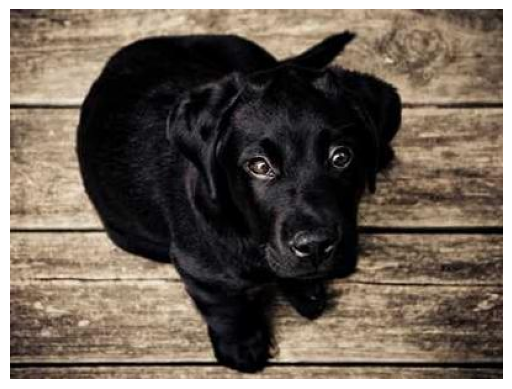

The image depicts a black puppy dog sitting on a wooden surface, gazing up at the camera. The puppy appears to be a Labrador Retriever, judging by its size and features. Its shiny black coat is well-groomed, and its ears are perked up, giving it a friendly and alert appearance. The puppy's large, dark eyes are expressive, and its nose is black and slightly wet, suggesting that it may have been recently fed or is anticipating food. The puppy's mouth is closed, and its front paws are tucked under its body, giving it a relaxed and contented posture.

The background of the image consists of a weathered wooden surface, likely a deck or floor, which provides a natural and rustic setting for the puppy. The overall atmosphere of the image is one of warmth and coziness, as if the puppy is enjoying a quiet moment in a comfortable environment.


In [62]:
# Multimodal inference
img = "https://picsum.photos/id/237/400/300"
#load_and_display_image_from_url(img)
response = model_inference(
    prompt="What do you see in this image?",
    image_source = img,
    model=model,
    processor=processor
).strip()
print(response)